In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Trigram model

In [2]:
#training data
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""
words = test_sentence.split()

In [3]:
trigrams = [([words[i], words[i+1]], words[i+2]) for i in range(len(words)-2)]
unique_words = set(words)
word_2_idx = {word:i for i, word in enumerate(unique_words)}

In [4]:
#take a look at trigrams
trigrams[:3]

[(['When', 'forty'], 'winters'),
 (['forty', 'winters'], 'shall'),
 (['winters', 'shall'], 'besiege')]

In [5]:
#built a simple trigram model
class NGramModel(nn.Module):
    def __init__(self, embedding_size, context_size, hidden_size, vocab_size):
        super(NGramModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.embed_to_hidden = nn.Linear(embedding_size*context_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input):
        embed = self.embedding_layer(input).view((1,-1))
        hidden = F.relu(self.embed_to_hidden(embed))
        logits = self.hidden_to_output(hidden)
        return logits

In [6]:
#define training parameters
EMBED_SIZE = 10
CONTEXT_SIZE = 2
HIDDEN_SIZE = 128

losses = list()
loss_func = nn.CrossEntropyLoss()
model = NGramModel(EMBED_SIZE, CONTEXT_SIZE, HIDDEN_SIZE, len(unique_words))
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [7]:
EPOCH = 10
for epoch in range(EPOCH):
    total_loss = 0.0
    for context, target in trigrams:
        #map context words to indexes, minibatch size = 1
        context_idx = torch.tensor([word_2_idx[word] for word in context], dtype=torch.long)
        #zero out gradients
        model.zero_grad()
        #take the input and make prediction
        output = model(context_idx)
        loss = loss_func(output, torch.tensor([word_2_idx[target]], dtype = torch.long))
        #backpropogation and update 
        loss.backward()
        optimizer.step()
        #get loss and add to total loss
        total_loss += loss.item()
    print("EPOCH: {}, Loss: {:.3f}".format(epoch, total_loss))
    losses.append(total_loss)

EPOCH: 0, Loss: 537.920
EPOCH: 1, Loss: 419.672
EPOCH: 2, Loss: 313.713
EPOCH: 3, Loss: 203.049
EPOCH: 4, Loss: 114.615
EPOCH: 5, Loss: 64.986
EPOCH: 6, Loss: 40.815
EPOCH: 7, Loss: 28.149
EPOCH: 8, Loss: 20.913
EPOCH: 9, Loss: 16.427


Text(0,0.5,'losses')

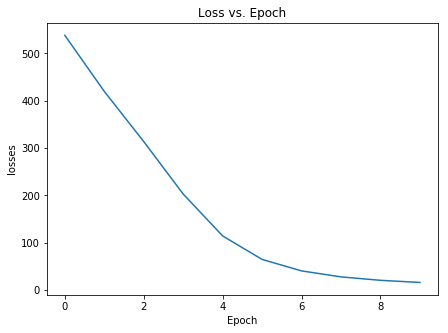

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.plot(losses)
ax.set_title("Loss vs. Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("losses")

In [9]:
#use the model to make prediction
model.eval()
sample_x = trigrams[10]
test_x = torch.tensor([word_2_idx[w] for w in sample_x[0]], dtype = torch.long)
y_pred = torch.max(model(test_x)[0],0)[1].item()

idx_2_word = {v:k for k,v in word_2_idx.items()}
print("Input context: {}, predicted word: {}, true word: {}".format(sample_x[0], idx_2_word[y_pred], sample_x[1]))

Input context: ['trenches', 'in'], predicted word: thy, true word: thy


## CBOW

In [10]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [11]:
class CBOW(nn.Module):
    
    def __init__(self, hidden_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        #this is the V embedding matrix
        self.embed_layer = nn.Embedding(vocab_size, embedding_size)
        self.Linear1 = nn.Linear(embedding_size, hidden_size)
        #this is the U embedding matrix
        self.Linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embed = sum(self.embed_layer(inputs)).view((1,-1))
        out = F.relu(self.Linear1(embed))
        logits = self.Linear2(out)
        return logits

    def get_embedding(self, word, word_2_idx):
        idx = torch.tensor([word_2_idx[word]], dtype = torch.long)
        return self.embed_layer(idx).view((1,-1))

In [12]:
#define parameters
hidden_size = 128
embedding_size = 100
EPOCH = 10

CBOW_model = CBOW(hidden_size, embedding_size, vocab_size)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(CBOW_model.parameters(), lr=1e-3)

In [13]:
cbow_loss = list()

for epoch in range(EPOCH):
    total_loss = 0.0
    for context, label in data:
        #get training data
        x_train = torch.tensor([word_to_ix[w] for w in context], dtype = torch.long)
        #zero gradients
        CBOW_model.zero_grad()
        #make prediction and compute loss
        preds = CBOW_model(x_train)
        loss = loss_func(preds, torch.tensor([word_to_ix[label]], dtype = torch.long))
        #backpropogate
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print("EPOCH: {}, Loss: {:.3f}".format(epoch, total_loss))
    cbow_loss.append(total_loss)

EPOCH: 0, Loss: 237.864
EPOCH: 1, Loss: 142.201
EPOCH: 2, Loss: 72.363
EPOCH: 3, Loss: 26.678
EPOCH: 4, Loss: 10.842
EPOCH: 5, Loss: 5.990
EPOCH: 6, Loss: 3.927
EPOCH: 7, Loss: 2.817
EPOCH: 8, Loss: 2.146
EPOCH: 9, Loss: 1.698


In [24]:
#use model to make prediction
CBOW_model.eval()

for i in range(5):
    #make 5 predictions
    random_idx = torch.randint(low = 0, high = len(data), size=(1,)).item()
    context, target = data[random_idx]
    x_test = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    y_pred = CBOW_model(x_test)
    pred_word = torch.max(y_pred[0], 0)[1].item()
    ix_to_word = {v:k for k,v in word_to_ix.items()}
    print("Context word: {}, true word: {}, pred word: {}".format(context, target, ix_to_word[pred_word]))

Context word: ['that', 'inhabit', 'As', 'they'], true word: computers., pred word: computers.
Context word: ['to', 'direct', 'In', 'effect,'], true word: processes., pred word: processes.
Context word: ['they', 'evolve,', 'manipulate', 'other'], true word: processes, pred word: processes
Context word: ['are', 'about', 'study', 'the'], true word: to, pred word: to
Context word: ['study', 'the', 'of', 'a'], true word: idea, pred word: idea
